#### What is Pneumonia?
Pneumonia is a form of acute respiratory infection that affects the lungs. The lungs are made up of small sacs called alveoli, which fill with air when a healthy person breathes. When an individual has pneumonia, the alveoli are filled with pus and fluid, which makes breathing painful and limits oxygen intake

#### How do Deep Learning Networks distinguish between healthy and unhealthy lungs?
Most deep neural network applied to the task of pneumonia diagnosis have been adapted from natural image classification. These models have a large number of parameters as well as high hardware requirements, which makes them prone to overfitting and harder to deploy in mobile settings. Some research on medical image classification by CNN has achieved performances rivaling human experts. For example, CheXNet, a CNN with 121 layers trained on a dataset with more than 100,000 frontal-view chest X-rays (ChestX-ray 14), achieved a better performance than the average performance of four radiologists

In [503]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [504]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS =20
CHANNELS = 1

**Hence the image has only two colors then it has to be converted to binary files**

In [505]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validate_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

seprating the data into there respecitve folders.
flow_from_directory, helps me to have access direclty to the directory where the dataset is save

In [506]:
train_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\train"),shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE), color_mode="grayscale",batch_size=BATCH_SIZE, seed=42)
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\test"),shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode="grayscale", batch_size=BATCH_SIZE, seed=42)
validate_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\val"),shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE), color_mode="grayscale",batch_size=BATCH_SIZE, seed=42)

Found 5216 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 15 files belonging to 2 classes.


**let's visulaize the data**

In [507]:
class_names = train_data.class_names

In [508]:
class_names

['NORMAL', 'PNEUMONIA']

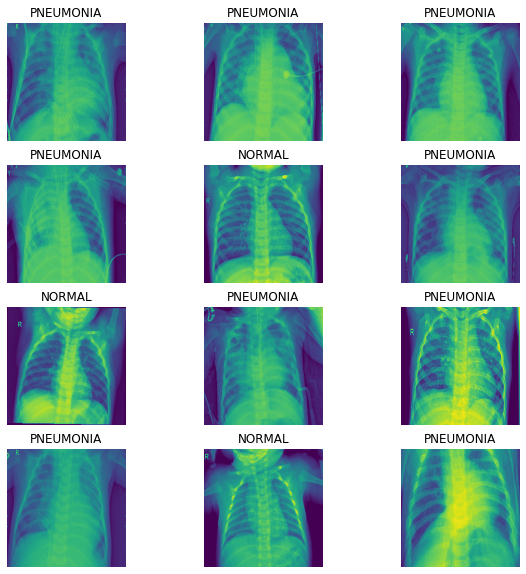

In [509]:
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
	for i in range(12):
		ax = plt.subplot(4,3,i+1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")


In [510]:
len(train_data)

163

**building the model and image preprocessing**

In [511]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = validate_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

IMAGE PREPROCESSING

In [512]:
resize_and_rescalling = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

DATA AGMENTAION

In [513]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [514]:
vgg = tf.keras.applications.VGG16(include_top = False,weights = "imagenet",input_shape =(IMAGE_SIZE, IMAGE_SIZE,3))

In [515]:
resnet50v2 = tf.keras.applications.ResNet50V2(include_top = False, 
                                  weights='imagenet', 
                                  input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

In [516]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
resnet50v2
model1 = models.Sequential([
resize_and_rescalling, 
data_augmentation,
layers.InputLayer(input_shape=(input_shape)), 

layers.Conv2D(128,(2,2),activation = "relu"),
layers.MaxPooling2D((2,2)),
	# first convolution with pooling
layers.Conv2D(128,(2,2),activation="relu"),
layers.MaxPooling2D(2,2),
# second convolution with pooling
layers.Conv2D(64,(2,2),activation="relu"),
layers.MaxPooling2D(2,2),
# third convolution with pooling
layers.Conv2D(64,(2,2),activation="relu"),
layers.MaxPooling2D(2,2),
# 4th convolution with pooling
layers.Conv2D(64,(2,2),activation="relu"),
layers.MaxPooling2D(2,2),
layers.GlobalAveragePooling2D(),
layers.Dense(64, activation="relu"),
layers.Dense(1, activation="sigmoid"),


])

In [517]:
model1.build(input_shape)

In [518]:
model1.summary()

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_76 (Sequential)  (32, 224, 224, 1)         0         
                                                                 
 sequential_77 (Sequential)  (32, 224, 224, 1)         0         
                                                                 
 input_56 (InputLayer)       multiple                  0         
                                                                 
 conv2d_257 (Conv2D)         (32, 223, 223, 128)       640       
                                                                 
 max_pooling2d_293 (MaxPooli  (32, 111, 111, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_258 (Conv2D)         (32, 110, 110, 128)       65664     
                                                     

In [519]:
model1.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits =False), optimizer="adam",metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc'),
                  tf.keras.metrics.AUC(name='prc', curve='PR')])

In [431]:
history = model1.fit(train_data,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=validate_data)

Epoch 1/5
163/163 [==============================] - 411s 2s/step - loss: 0.5882 - accuracy: 0.7402 - precision: 0.7431 - recall: 0.9941 - auc: 0.4382 - prc: 0.7071 - val_loss: 0.8211 - val_accuracy: 0.4667 - val_precision: 0.4667 - val_recall: 1.0000 - val_auc: 0.3839 - val_prc: 0.3745
Epoch 2/5
163/163 [==============================] - 400s 2s/step - loss: 0.5517 - accuracy: 0.7381 - precision: 0.7447 - recall: 0.9853 - auc: 0.6252 - prc: 0.8276 - val_loss: 0.8379 - val_accuracy: 0.4667 - val_precision: 0.4667 - val_recall: 1.0000 - val_auc: 0.6786 - val_prc: 0.5677
Epoch 3/5
163/163 [==============================] - 397s 2s/step - loss: 0.4550 - accuracy: 0.7584 - precision: 0.7828 - recall: 0.9339 - auc: 0.7896 - prc: 0.9144 - val_loss: 0.6501 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.2857 - val_auc: 0.6518 - val_prc: 0.6265
Epoch 4/5
163/163 [==============================] - 393s 2s/step - loss: 0.4090 - accuracy: 0.8023 - precision: 0.8332 - recall: 0.9177

In [432]:
model1_score = model1.evaluate(test_data)

19/19 [==============================] - 14s 670ms/step - loss: 0.7660 - accuracy: 0.5641 - precision: 0.7545 - recall: 0.4580 - auc: 0.6709 - prc: 0.7046


In [520]:
model1_score

[0.7659726142883301,
 0.5641025900840759,
 0.7544642686843872,
 0.45799458026885986,
 0.6709073781967163,
 0.7045801877975464]

<AxesSubplot:>

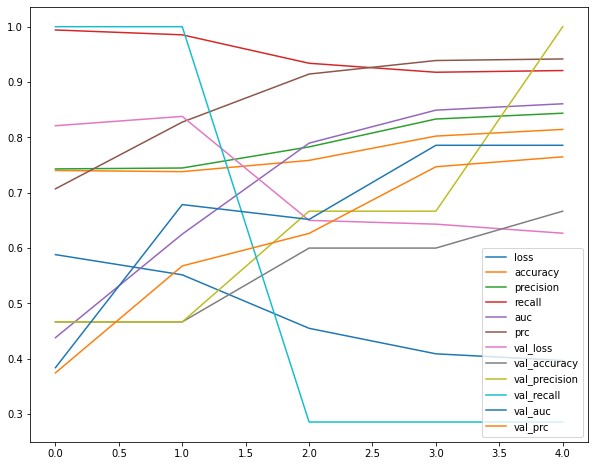

In [527]:
pd.DataFrame(history.history).plot(figsize=(10,8))

In [482]:
# acc = history.history["accuracy"]
# val_acc = history.history["val_accuracy"]
# loss = history.history["loss"]
# val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validating accuracy')

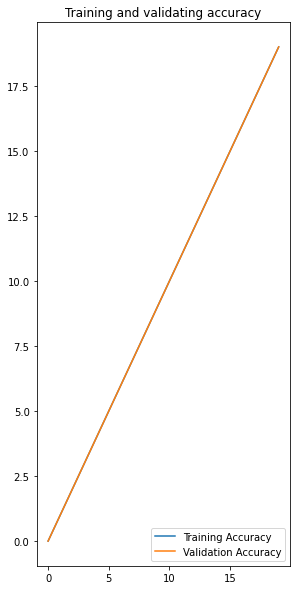

In [522]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), label = "Training Accuracy") #acc,
plt.plot(range(EPOCHS),label = "Validation Accuracy") #, val_acc
plt.legend(loc ="lower right")
plt.title("Training and validating accuracy")

**predicting images**

first image to predict
first image actual label is: NORMAL
Predicted label NORMAL


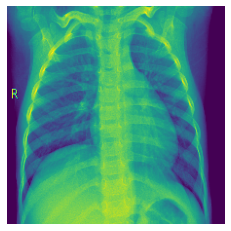

In [523]:
for images_batch, labels_batch in test_data.take(1):
    first_images = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_images)
    print("first image actual label is:", class_names[first_label])
    batch_prediction = model1.predict(images_batch)
    print("Predicted label",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [524]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # creating a batch of the network
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]),2)
    return predicted_class, confidence

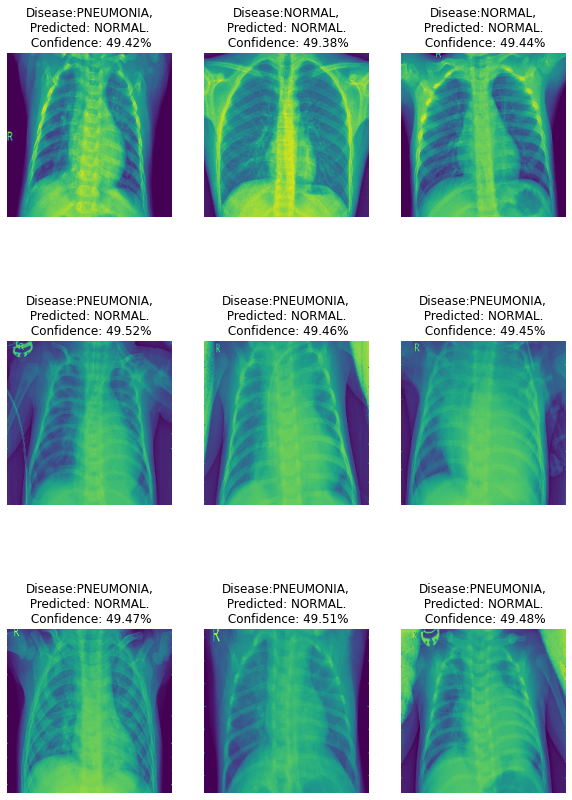

In [525]:
plt.figure(figsize=(10,15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Disease:{actual_class },\n Predicted: {predicted_class}. \n Confidence: {confidence}%",)
        plt.axis("off")

In [526]:
tf.keras.models.save_model(model1,"save_models/x_ray_model.hdf5")

#### Implementing Transfer Learning using VGG and Resnet

In [441]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model_vgg  = tf.keras.Sequential([
        vgg,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(IMAGE_SIZE, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [442]:
model_vgg.build(input_shape)

In [443]:
model_vgg.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
               metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc'),
                  tf.keras.metrics.AUC(name='prc', curve='PR')],  
                  optimizer = "adam")
model_vgg.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_47 (Flatten)        (None, 25088)             0         
                                                                 
 dense_96 (Dense)            (None, 224)               5619936   
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense_97 (Dense)            (None, 1)                 225       
                                                                 
Total params: 20,334,849
Trainable params: 20,334,849
Non-trainable params: 0
_________________________________________________________________


In [444]:
train_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\train"), shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE), color_mode="rgb",batch_size=BATCH_SIZE, seed=42,)
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\test"), shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode="rgb", batch_size=BATCH_SIZE, seed=42,)
validate_data= tf.keras.preprocessing.image_dataset_from_directory(directory=(r"C:\Users\LENOVO\Desktop\Ayush Assignments\chest-xray\medical\training\chest_xray\val"), shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE), color_mode="rgb",batch_size=BATCH_SIZE, seed=42,)

Found 5216 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 15 files belonging to 2 classes.


In [445]:
history2 = model_vgg.fit(train_data,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=validate_data)


Epoch 1/5
163/163 [==============================] - 2975s 18s/step - loss: 12.2762 - accuracy: 0.7929 - precision: 0.8477 - recall: 0.8792 - auc: 0.8139 - prc: 0.9061 - val_loss: 1.0338 - val_accuracy: 0.6667 - val_precision: 0.5833 - val_recall: 1.0000 - val_auc: 0.8929 - val_prc: 0.9044
Epoch 2/5
163/163 [==============================] - 3394s 21s/step - loss: 0.3484 - accuracy: 0.8679 - precision: 0.9164 - recall: 0.9048 - auc: 0.9143 - prc: 0.9620 - val_loss: 1.1648 - val_accuracy: 0.6000 - val_precision: 0.5385 - val_recall: 1.0000 - val_auc: 0.8482 - val_prc: 0.7883
Epoch 3/5
163/163 [==============================] - 2940s 18s/step - loss: 0.2325 - accuracy: 0.9130 - precision: 0.9419 - recall: 0.9409 - auc: 0.9575 - prc: 0.9836 - val_loss: 0.4317 - val_accuracy: 0.8667 - val_precision: 0.8571 - val_recall: 0.8571 - val_auc: 0.9286 - val_prc: 0.9328
Epoch 4/5
163/163 [==============================] - 2892s 18s/step - loss: 0.2026 - accuracy: 0.9340 - precision: 0.9570 - recal

In [446]:
tf.keras.models.save_model(model_vgg,"save_models/vgg_model.hdf5")

<AxesSubplot:>

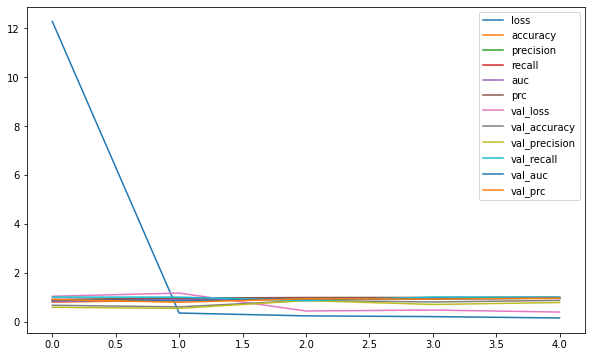

In [528]:
pd.DataFrame(history2.history).plot(figsize=(10,6))

In [448]:
model2_score = model_vgg.evaluate(test_data)

19/19 [==============================] - 103s 5s/step - loss: 1.0867 - accuracy: 0.7829 - precision: 0.7490 - recall: 0.9864 - auc: 0.8415 - prc: 0.8571


In [449]:
model2_score

[1.0867215394973755,
 0.7829059958457947,
 0.748971164226532,
 0.9864498376846313,
 0.841457188129425,
 0.8571090698242188]

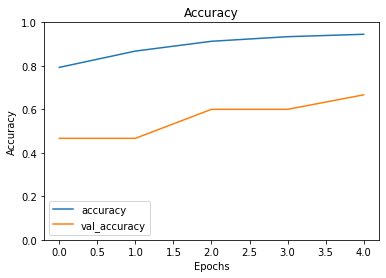

In [491]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title("Accuracy")
plt.legend()
plt.show()

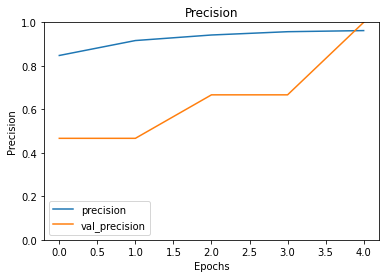

In [492]:
plt.plot(history2.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label = 'val_precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title("Precision")
plt.legend()
plt.show()

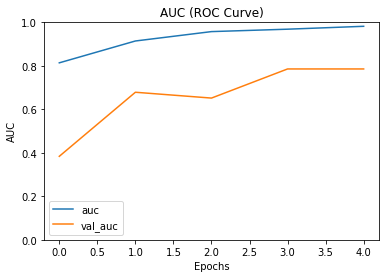

In [494]:
plt.plot(history2.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label = 'val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.title("AUC (ROC Curve)")
plt.legend()
plt.show()

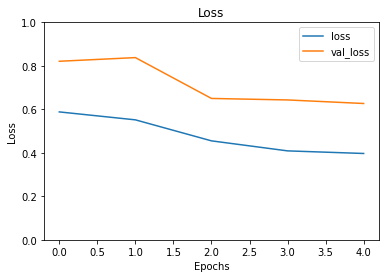

In [495]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title("Loss")
plt.legend()
plt.show()

In [463]:
# y_pred = np.round(model_vgg.predict(test_data)).flatten()
# y_true = train_data.classes
# (ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Normal', 'Pneumonia']).plot())